In [1]:
import numpy as np
import sys
import dimod
import matplotlib.pyplot as plt
import os
import re
import neal
import math

from dwave.system import EmbeddingComposite, DWaveSampler
from dwave_qbsolv import QBSolv
from pyqubo import Spin, Array
from embedding_generator import generate_embedding

In [20]:
# Observed big difference in obtained minimum when increasing the number of reads from 100 to 1000
num_reads = 100
num_events = 1000
num_iter = 40

path = '/Users/1zd/quantumjets/pythiaEvents/'

theta = np.pi/2.

sampler = EmbeddingComposite(DWaveSampler(solver='Advantage_system1.1'))
sa_sampler = neal.SimulatedAnnealingSampler()

rcs = np.linspace(0.25, 2.0, 8)
rcs_2 = np.linspace(0.05, 0.2, 5)
rcsall = np.array([0.05  , 0.0875, 0.125 , 0.1625, 0.2 , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ])

In [21]:
rcsall

array([0.05  , 0.0875, 0.125 , 0.1625, 0.2   , 0.25  , 0.5   , 0.75  ,
       1.    , 1.25  , 1.5   , 1.75  , 2.    ])

In [5]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

In [23]:
for ev in range(32,33):
    print('Event Number %s' %ev)
    fout_name = path + 'chain_strength_scan_Ev' + str(ev) + '.dat'
    print(ev)

    with open(fout_name, 'w') as fout:

        fname = path + 'Event_' + str(ev) + '.dat'
        f = open(fname)

        pat = re.compile(r"\s+")

        g = list(zip(*[ pat.sub(" ",x.strip()).split() for x in f]))

        px = np.array([ float(x) for x in g[0]])
        py = np.array([ float(x) for x in g[1]])
        pz = np.array([ float(x) for x in g[2]])
        e = np.array([ float(x) for x in g[3]])

        # Generate qubo

        n_part = len(px)
        print('Number of particles: %s' %n_part)
        s = Array.create('s', shape=n_part, vartype='BINARY')

        # Create an array of zeroes for qubo matrix coefficients
        coeff = [[0] * n_part for _ in range(n_part)] 

        for i in range(0,n_part):
            for j in range(0,n_part):
                coeff[i][j] = (px[i]*px[j] +py[i]*py[j] + pz[i]*pz[j] - e[i]*e[j] * np.cos(theta))/(1 - np.cos(theta))

        # Construct Hamiltonian
        H = sum([ -1.0*coeff[i][j]*s[i]*s[j] for i in range(0,n_part) for j in range(0,n_part)])

        # Compile model using pyqubo

        model = H.compile()
        qubo, offset = model.to_qubo()

        sum_mom = sum([np.sqrt(px[i]*px[i] + py[i]*py[i]+ pz[i]*pz[i])  for i in range(0,n_part)])

        # Submit problem to D-Wave
        yvals = {}
        for r in rcs:
            y_list = []
            counter = 0
            ch_str = qubo[max(qubo, key=qubo.get)]*r
            print('Relative Strength: %s' %r)
            for i in range(num_iter):
                response = sampler.sample_qubo(qubo, num_reads = 10000, chain_strength=ch_str)
                #response.first.energy
                dthrust = 2.*np.sqrt(-1.*response.first.energy)/sum_mom
                #print(truncate(dthrust,6))
                y_list.append(truncate(dthrust,6))
                if(truncate(dthrust,6) == 0.973528): 
                    counter += 1
            yvals[r] = y_list
            print(counter)

Event Number 32
32
Number of particles: 39
Relative Strength: 0.25
38
Relative Strength: 0.5
10
Relative Strength: 0.75
1
Relative Strength: 1.0


KeyboardInterrupt: 

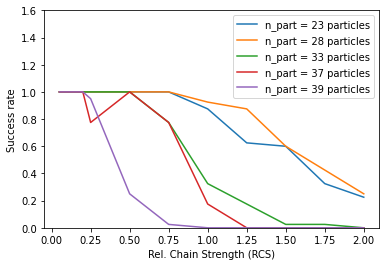

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns

y_0 =   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,1.0,1.0,0.925,0.875, 0.6, 0.425, 0.25]
y_1 =   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,1.0,0.775,0.325,0.175,0.025,0.025,0.0]
y_31 =  [1.0, 1.0, 1.0, 1.0, 1.0, 0.775, 1.0, 0.775, 0.175, 0.0, 0.0, 0.0, 0.0]
y_9   = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,   1.0,   1.0, 0.875, 0.625, 0.6, 0.325, 0.225] 
y_32  = [1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.25, 0.025, 0.0,   0.0,   0.0, 0.0 ,  0.0 ]
sns.lineplot(rcsall, y_9, label = 'n_part = 23 particles' )
sns.lineplot(rcsall, y_0, label = 'n_part = 28 particles' )
sns.lineplot(rcsall, y_1, label = 'n_part = 33 particles')
sns.lineplot(rcsall, y_31, label = 'n_part = 37 particles')
sns.lineplot(rcsall, y_32, label = 'n_part = 39 particles')

plt.xlabel('Rel. Chain Strength (RCS)')
plt.ylabel('Success rate')
plt.ylim(0.0, 1.6)
#plt.xscale('log')

plt.savefig("plots/chain_strength_scan.png")